In [1]:
import matplotlib.pyplot as plt
import torch
import argparse
import os
import cv2
import sys
import numpy as np
from object_detection import ObjectDetector
from fchardnet_segmentation import FCHarDNetSemanticSegmentation
from helpers import warped2scan, warp_driveable, get_driveable_mask,get_driveable_mask2
import math
%matplotlib inline

# Test Segmentation

In [2]:
torch.backends.cudnn.benchmark = True

## Additional helper functions

In [3]:
def plot_segmendet_image(img, img_decoded):
    image=img.astype(np.float32)/255.0
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original = image.copy()
    original = cv2.resize(original,(img_decoded.shape[1], img_decoded.shape[0]))
    plt.imshow(np.concatenate((original, img_decoded), axis=0))
    plt.show()


In [4]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        #print(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

def seg2scan(driveable_area):
    h,w,_ = driveable_area.shape
    warped = cv2.warpPerspective(driveable_area, M, (480, 480), flags=cv2.INTER_LINEAR)
    original_center = np.array([[[w/2,h]]],dtype=np.float32)
    warped_center = cv2.perspectiveTransform(original_center, M)[0][0]
    scan_distances, angle_increment, warped_contours = warped2scan(warped, warped_center)
    return warped, warped_contours, scan_distances, angle_increment

def get_driveable(driveable_area):
    h,w,_ = driveable_area.shape
    # Warp driveable area
    warped = cv2.warpPerspective(driveable_area, M, (480, 480), flags=cv2.INTER_LINEAR)
    # Warp decoded image from semantic segmentation
#     warped_decoded = cv2.warpPerspective(img_decoded, M, (480, 480), flags=cv2.INTER_LINEAR)
    # Calculate robot center
    original_center = np.array([[[w/2,h]]],dtype=np.float32)
    warped_center = cv2.perspectiveTransform(original_center, M)[0][0]    
    
    driveable_contour_mask = get_driveable_mask2(warped, warped_center)

    return driveable_contour_mask

## Load models

In [6]:
segmentation_model_path = os.path.join('/usr/src/app/dev_ws/src/vision/vision', 'pretrained', 'hardnet70_cityscapes_model.pkl')
seg_model = FCHarDNetSemanticSegmentation(segmentation_model_path)
object_detector = ObjectDetector('/usr/src/app/dev_ws/src/vision/vision/pretrained/yolov5s.pt')
# Load perspective transforms
mtxs = np.load('/usr/src/app/dev_ws/src/vision/vision/PerspectiveTransform.npz')
M = mtxs['M']
M_inv = mtxs['M_inv']

Semantic Segmentation using FCHardNet
Loading Object Detection


## Read image

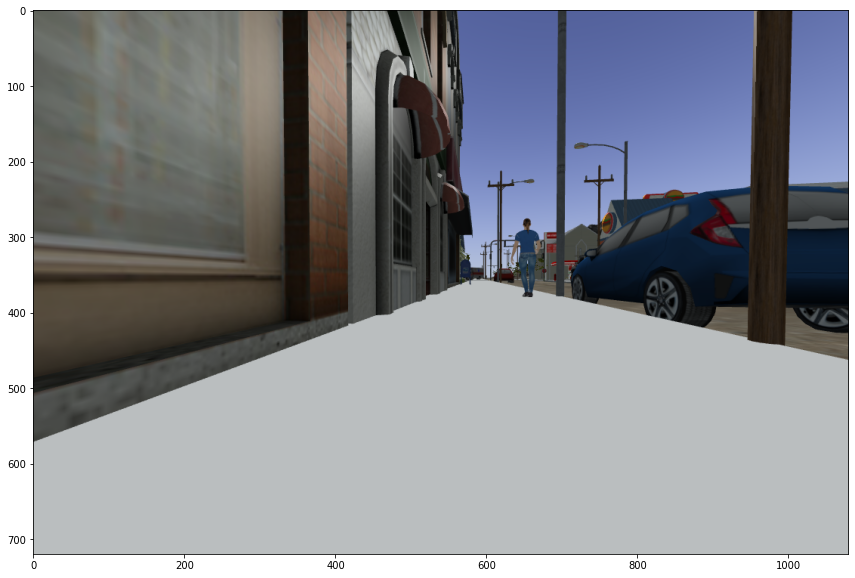

In [7]:
# img = cv2.imread("./data/72.png")
img = cv2.imread("./data/63.png")
h_orig,w_orig,_ = img.shape
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(img)
plt.show()

# Process image
## Semantic Segmentation

(720, 1080, 3)


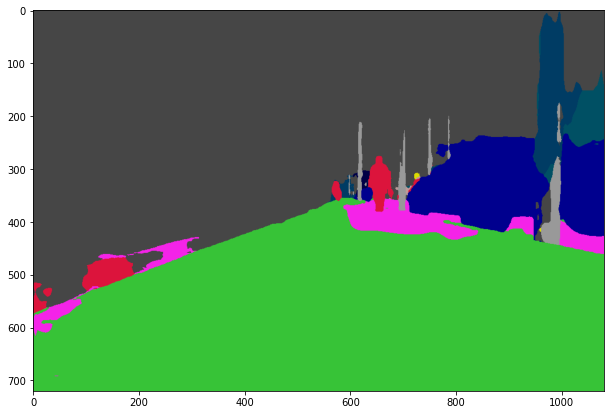

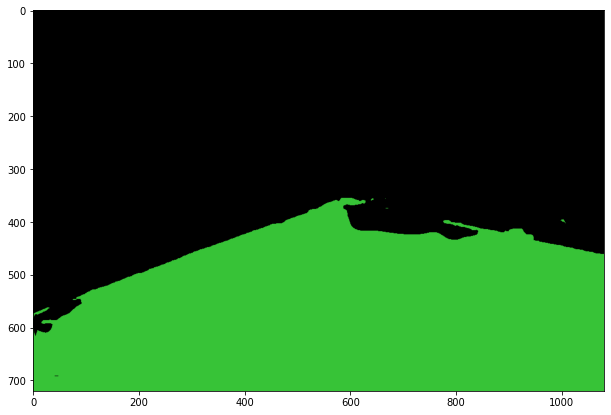

NameError: name 'PIXEL_PER_METER_Y' is not defined

In [8]:
img_test = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_decoded, driveable_decoded = seg_model.process_img_driveable(img_test,[h_orig,w_orig])

fig, ax = plt.subplots(figsize=(14, 7))
ax.imshow(img_decoded)
plt.show()
fig, ax = plt.subplots(figsize=(14, 7))
ax.imshow(driveable_decoded)
plt.show()

# Warp image
warped_original, warped_contours, scan_distances, angle_increment = seg2scan(driveable_decoded)
unwarped_driveable = cv2.warpPerspective(warped_contours, M_inv, (w_orig,h_orig), flags=cv2.INTER_LINEAR)
out_driveable = cv2.addWeighted(img, 0.7, unwarped_driveable, 0.3, 0)

fig, ax = plt.subplots(figsize=(14, 7))
ax.imshow(out_driveable)
plt.show()

fig, ax = plt.subplots(figsize=(14, 7))
ax.imshow(warped_original)
plt.show()

## Bird-eye view

(480, 480)


/usr/src/app/dev_ws/src/vision/vision/helpers.py:144: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  scan_array = np.array(([scan_distances, scan_angles, scan_points])).T


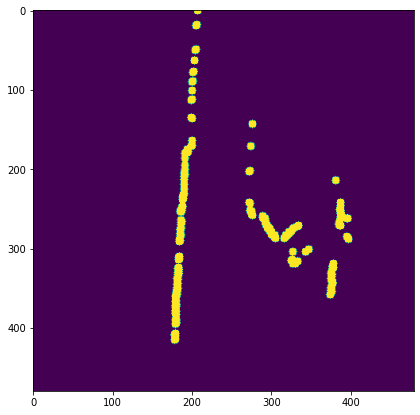

In [8]:
driveable_mask  = get_driveable(driveable_decoded)
print(driveable_mask.shape)
fig, ax = plt.subplots(figsize=(14, 7))
ax.imshow(driveable_mask)
plt.show()


## Object Detection

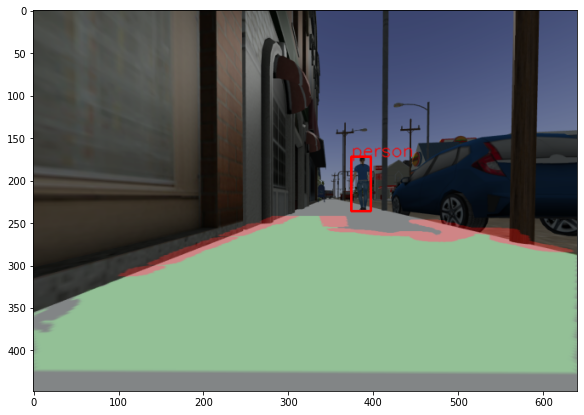

In [9]:
preds = object_detector.process_frame(img)
out_driveable_detections = object_detector.draw_rectangles(out_driveable, preds)
fig, ax = plt.subplots(figsize=(14, 7))
ax.imshow(out_driveable_detections)
plt.show()

**preds:** numpy array with all object predictions

**driveable_mask:** bird-eye view driveable area limits from semantic segmentation

**roi_mask:** bird-eye view mask of the area inside the fov of the camera

## Create local cost map
### Visualize detections in image

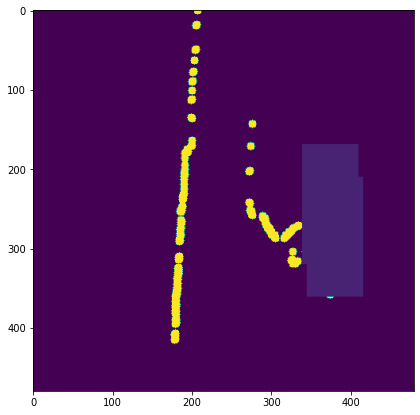

In [34]:
driveable_mask_color = driveable_mask.copy()
h,w,_ = out_driveable_detections.shape
h_rate = h_orig/h
w_rate = w_orig/w

for pred in preds:
    if(pred[4] > object_detector.conf_thres):
        x = w_rate*(pred[0]+pred[2])/2.0
        y = h_rate*pred[3]
        if(pred[5]==0): #person
            wr = 50
            hr = 50
            color = 50
        else:
            wr = 70
            hr = 150
            color = 25
        pos_orig = np.array([[[x,y]]],dtype=np.float32)
        
        warped_birdview = cv2.perspectiveTransform(pos_orig, M)[0][0] 
        warped_birdview = np.uint16(warped_birdview)
        cv2.rectangle(driveable_mask_color, (warped_birdview[0] -int(wr/2), warped_birdview[1]-int(hr/2)), (warped_birdview[0] +int(wr/2), warped_birdview[1]+int(hr/2)), color, -1)
fig, ax = plt.subplots(figsize=(14, 7))
ax.imshow(driveable_mask_color)
plt.show()     

## Find sidewalk edge lines

-0.06521937417529261


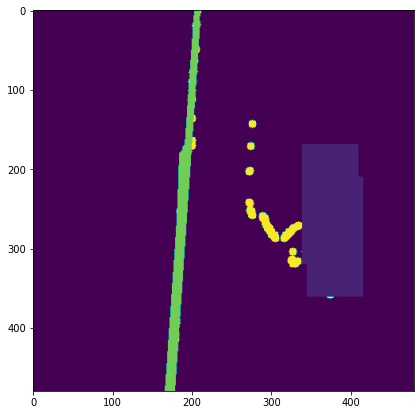

In [35]:
driveable_mask2 = np.uint8(driveable_mask)
HEIGHT=480
WIDTH=480

# cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
lines = cv2.HoughLinesP(driveable_mask2, 5, 2*np.pi / 180, 100, None, 210, 50)
#lines = cv2.HoughLinesP(driveable_mask4,rho,theta,2,minLineLength,maxLineGap)
line_angles = []
horizontal_angles = []

if(lines is not None):
    for line in lines:
        for x1,y1,x2,y2 in line:
            if(y2<y1):
                angle = -math.atan2(y2-y1,x2-x1)-math.pi/2
            else:
                angle = -math.atan2(y1-y2,x1-x2)-math.pi/2
            line_angles.append(angle)
            if(x2 != x1):
                m = (y2-y1)/(x2-x1)
                b = y1-m*x1
#                 print(m)
#                 print(b)

                x3 = ((HEIGHT-b)/m)
#                 print(x3)
                x3 = round(x3)
            else:
                x3 = x1
            
            if x3>0 and x3<WIDTH:
                cv2.line(driveable_mask_color,(x3,HEIGHT),(x2,y2),200,3)
            else:
                cv2.line(driveable_mask_color,(x1,y1),(x2,y2),200,3)
                
                
angle_avg = np.average(line_angles)
print(angle_avg)
fig, ax = plt.subplots(figsize=(14, 7))
ax.imshow(driveable_mask_color)
plt.show() 

### Create obstacle cost map

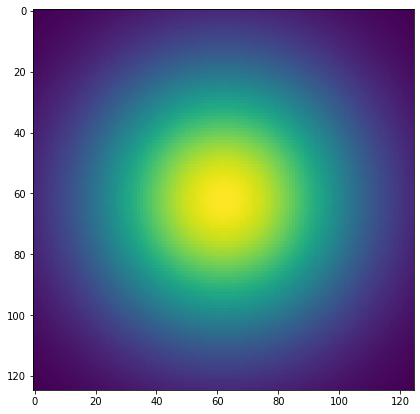

(480, 480)
(480, 480)
40393.284534346305


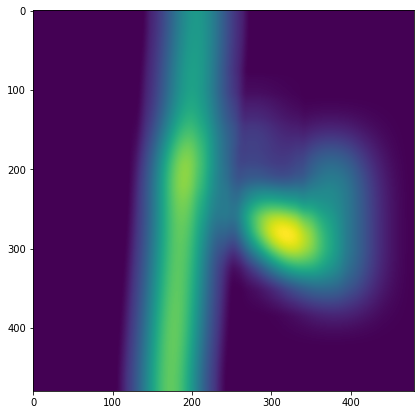

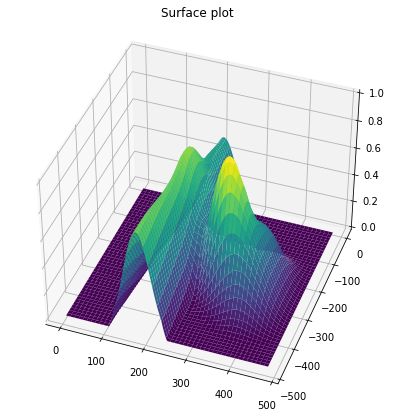

In [15]:
# define normalized 2D gaussian
def gaus2d(x=0, y=0, mx=0, my=0, sx=1, sy=1):
    return 1. / (2. * np.pi * sx * sy) * np.exp(-((x - mx)**2. / (2. * sx**2.) + (y - my)**2. / (2. * sy**2.)))

x = np.linspace(-2, 2,125)
y = np.linspace(-2, 2,125)
x, y = np.meshgrid(x, y) # get 2D variables instead of 1D
z = 1*gaus2d(x, y)
fig, ax = plt.subplots(figsize=(14, 7))
ax.imshow(z*10)
plt.show()
#filter the source image
print(driveable_mask_color.shape)
print(driveable_mask2.shape)
driveable_mask2 = np.float32(driveable_mask2)
z = np.float32(z)

cost_obst = cv2.filter2D(driveable_mask_color,-1,z)
print(np.amax(cost_obst))
cost_obst/=np.amax(cost_obst)
fig, ax = plt.subplots(figsize=(14, 7))
ax.imshow(cost_obst)
plt.show()     

## 3D-plot
fig = plt.figure(figsize=(14, 7))
ax = plt.axes(projection='3d')
x = np.arange(480)
y = -np.arange(480)
X, Y = np.meshgrid(x, y)
Z = cost_obst.reshape(X.shape)

ax.plot_surface(X, Y, Z,cmap='viridis', edgecolor='none')
ax.set_title('Surface plot')
ax.view_init(40, -70)
plt.show()

### Create inclination plane

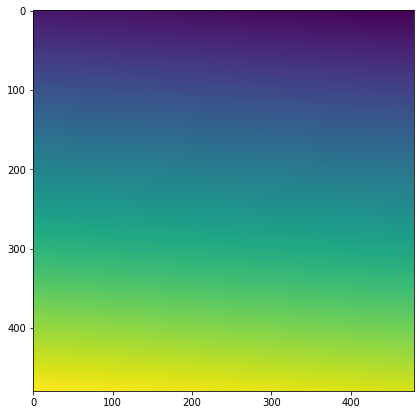

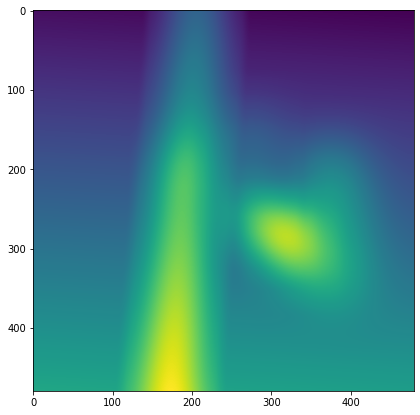

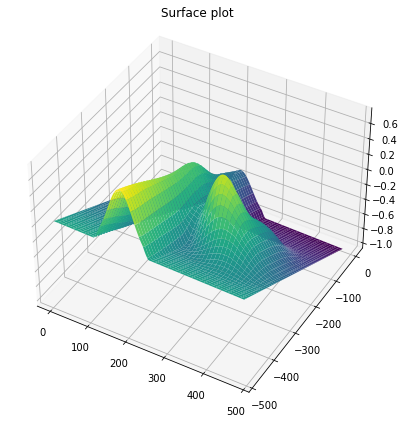

In [16]:
from mpl_toolkits.mplot3d import Axes3D
point = np.array([WIDTH/2, HEIGHT, 0])
# angle_avg = math.pi/4
normal = np.array([math.tan(-angle_avg),-1,HEIGHT])
# a plane is a*x+b*y+c*z+d=0
# [a,b,c] is the normal. Thus, we have to calculate
# d and we're set
d = -np.sum(point*normal)# dot product
xx, yy = np.meshgrid(range(WIDTH), range(HEIGHT))
cost_forward = (-normal[0]*xx - normal[1]*yy - d)*1./normal[2]
fig, ax = plt.subplots(figsize=(14, 7))
ax.imshow(cost_forward)
plt.show()  

cost_fcn = cost_obst+cost_forward*1.0
fig, ax = plt.subplots(figsize=(14, 7))
ax.imshow(cost_fcn)
plt.show()   
fig = plt.figure(figsize=(14, 7))
ax = plt.axes(projection='3d')

ax.plot_surface(X, Y, cost_fcn,cmap='viridis', edgecolor='none')
ax.set_title('Surface plot')
ax.view_init(40, -60)
plt.show()

## Path Planning

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


outside potential!
outside potential!
Oscillation detected at (253,332)!
Goal!!


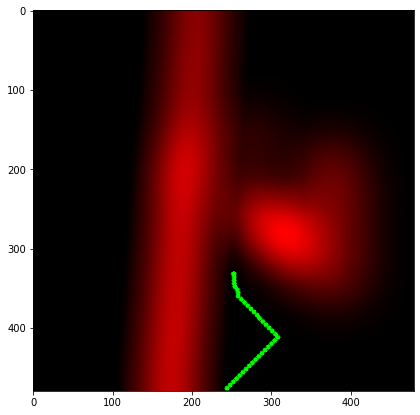

In [17]:
HEIGHT = 480
WIDTH = 480
PIXEL_PER_METER_X = (WIDTH - 2*150)/3.0 #Horizontal distance between src points in the real world ( I assumed 3.0 meters)
PIXEL_PER_METER_Y = (HEIGHT - 20-55)/6.0 #Vertical distance between src points in the real world ( I assumed 6.0 meters)
OSCILLATIONS_DETECTION_LENGTH = 3
from collections import deque
    
    

def get_motion_model():
    # dx, dy
    motion = [
              [1, 0], #right
#               [0, 2], #back
              [-1, 0], #left
              [0, -4], # front
              [-1, -4],#front-left
              [-2, -4],#front-left
              [-3, -4],#front-left
              [-4, -4],#front-left
#               [-1, 2], # back-left
              [1, -4], #front-right
              [2, -4], #front-right
              [3, -4], #front-right
              [4, -4], #front-right
#               [1, 1]  #back-right
              ]
    return motion

def oscillations_detection(previous_ids, ix, iy):
    previous_ids.append((ix, iy))

    if (len(previous_ids) > OSCILLATIONS_DETECTION_LENGTH):
        previous_ids.popleft()

    # check if contains any duplicates by copying into a set
    previous_ids_set = set()
    for index in previous_ids:
        if index in previous_ids_set:
            return True
        else:
            previous_ids_set.add(index)
    return False

output = cost_fcn.copy()*0
motion = get_motion_model()
previous_ids = deque()
ix = round(WIDTH/2)
iy = round(HEIGHT)


pmap = cost_fcn.copy()


while(ix > 5 and iy > 50):
    minp = float("inf")
    minix, miniy = -1, -1
#     print('=========================')
    for i, _ in enumerate(motion):
        inx = int(ix + 1*motion[i][0])
        iny = int(iy + 1*motion[i][1])
        if inx >= WIDTH or iny >= HEIGHT or inx < 0 or iny < 0:
            p = float("inf")  # outside area
            print("outside potential!")
#             break
        else:
            p = pmap[iny][inx]
#         print('motion: {}'.format(motion[i]))
#         print('p: {}'.format(p))
        if minp > p:
            min_motion = motion[i]
            minp = p
            minix = inx
            miniy = iny
#     print('min_motion: {}'.format(min_motion))
    ix = minix
    iy = miniy
#     print("----------ix: {}, iy: {}".format(ix,iy))
#     print(iy)
    if (oscillations_detection(previous_ids, ix, iy)):
        print("Oscillation detected at ({},{})!".format(ix, iy))
        break
    cv2.circle(output, (ix, iy),int(3.0),1, -1)
    
print("Goal!!")
output_path = cv2.merge([cost_obst, output, cost_fcn*0])

fig, ax = plt.subplots(figsize=(14, 7))
ax.imshow(output_path)
plt.show()   

### Unwarp

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


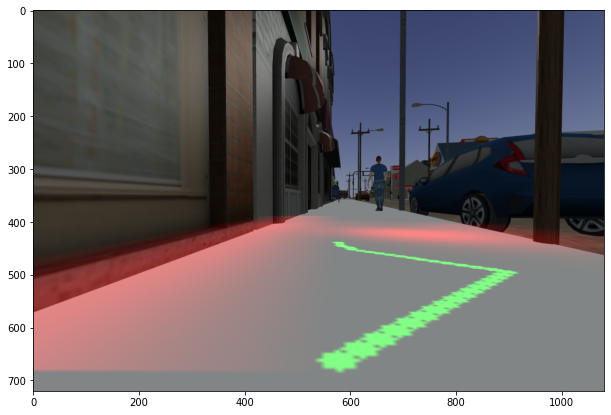

In [18]:
unwarped_path = cv2.warpPerspective(output_path, M_inv, (w_orig,h_orig), flags=cv2.INTER_LINEAR)


output = cv2.addWeighted(np.float64(img)/255.0, 0.7, unwarped_path, 0.5, 0)
fig, ax = plt.subplots(figsize=(14, 7))
ax.imshow(output)
plt.show()  

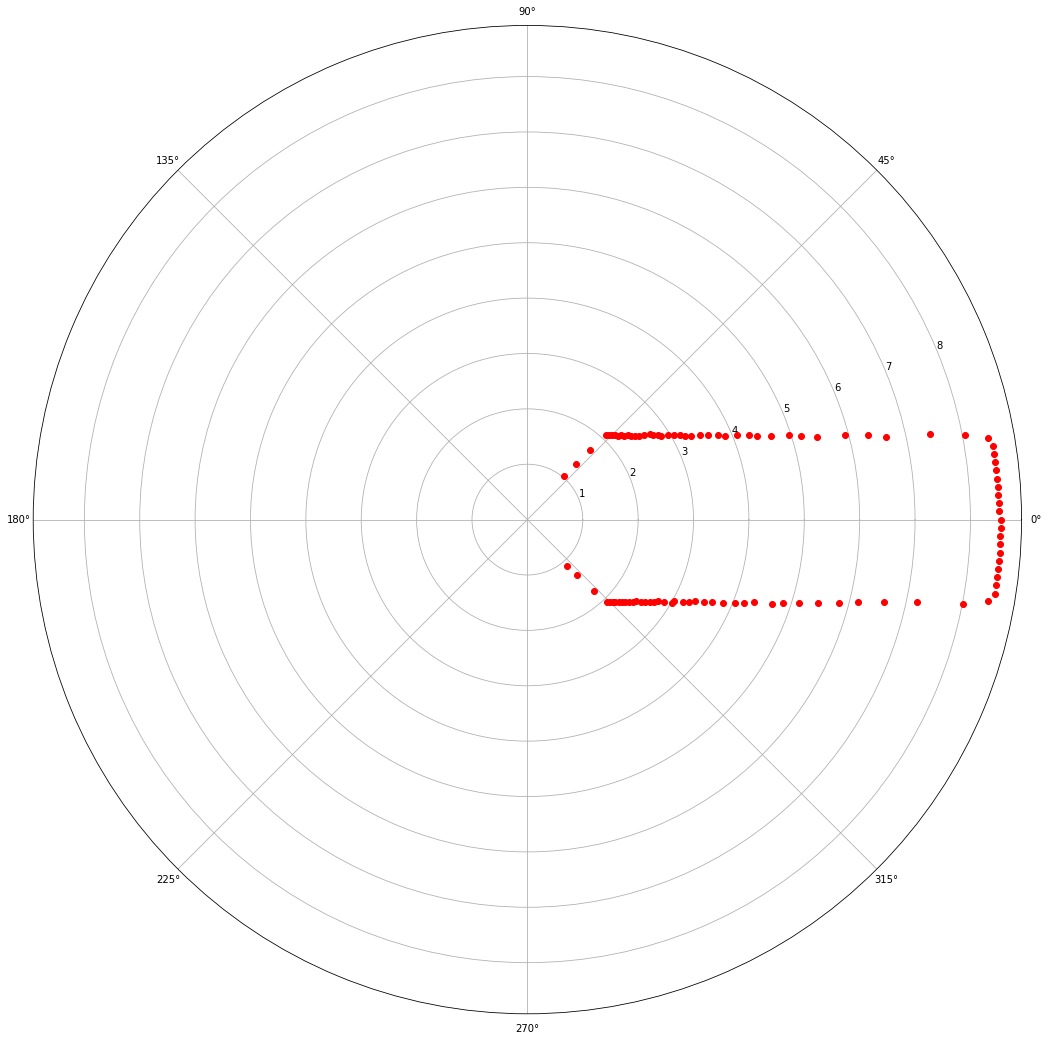

In [58]:
fig = plt.figure(figsize=(20, 40))
ax = plt.subplot(2, 1, 2, projection='polar')
for p, theta in zip(scan_distances,scan_angles):
    plt.polar(-theta, p, 'ro') #invert the angle just for visualization purposes
plt.show()